In [6]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Generate fake

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def normalize(x):
    # Normalize according to: Normalization
    x_min = x.min()
    x_max = x.max()
    
    if (x_max -x_min) == 0:
         x = np.zeros_like(x)
    else:
        x = (x-x_min)/(x_max -x_min)
    return x


In [9]:


def normalize(x):
    # Normalize according to: Standardizatio
    # https://stackabuse.com/feature-scaling-data-with-scikit-learn-for-machine-learning-in-python/
    x_mean = x.mean()
    x_std = x.std()
    
    if x_std == 0:
        x = np.zeros_like(x)
    else:
        x = (x-x_mean)/(x_std)
    return x

def plot_example(select_samples, fail=1):
    sample_from = random.randint(min(data_info[f"index_{fail}"]), max(data_info[f"index_{fail}"])-select_samples)
    fig, ax = plt.subplots(select_samples,1,figsize=(12,12))
    for i,j in enumerate(range(sample_from, sample_from+select_samples)):

        ax[i].plot(data[j][0].T)
    plt.show()


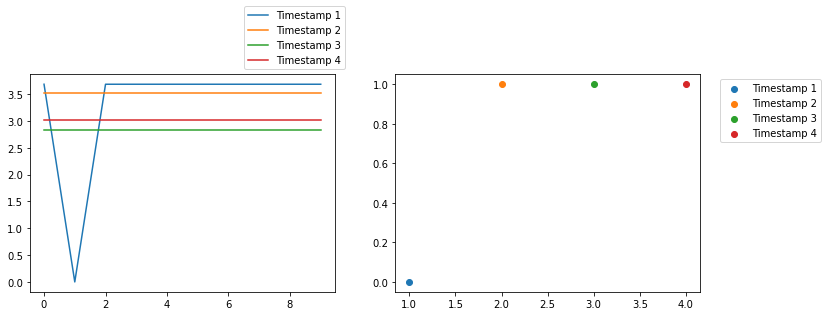

In [11]:
time_steps = 5
n_cells = 10 # Amount of cells in pack
x = np.zeros([time_steps,n_cells])


fig, ax = plt.subplots(1,2,figsize=(12,4))

failed_cell = 1 # Which cell is the failing cell
is_fail = True# Does the pack include a failed cell
volt_stochastic = 0.5
for i in range(1,time_steps):
    sigma = 0.0 # How much is the fluctuation
    median = random.uniform(2, 4)
    volt = np.random.normal(loc=median, scale=sigma, size=n_cells)
    y = 1
    if is_fail:
        r = random.random()
        if r < volt_stochastic:
            stochstic_amplifier = random.randint(1,10)
            
            y = (1-i/stochstic_amplifier)
            #print(y)
            volt[failed_cell]*=y
    ax[1].scatter(i,y,label=f"Timestamp {i}")
    ax[1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    ax[1] = plt.gca()
    #ax[1].set_ylim(ax[1].get_ylim()[::-1])
    x[i,:] = volt
            
    ax[0].plot(volt,label=f"Timestamp {i}")
    ax[0].legend(bbox_to_anchor=(1.05, 1.0), loc='lower right')
#plt.ylim(0,16)
#plt.legend()



#plt.scatter(x_arr, y_arr)
#ax = plt.gca()
#ax.set_ylim(ax.get_ylim()[::-1])

In [12]:
def create_sequence(time_steps=2, n_cells=4, failed_cell=1, is_fail=True, sigma=0.0, volt_stochastic = 0.9, normalize_x=False):
    x = np.zeros([time_steps,n_cells])
    for i in range(0,time_steps):
        median = random.uniform(2, 4)
        volt = np.random.normal(loc=median, scale=sigma, size=n_cells)
        if is_fail:
            r = random.random()
            if r < volt_stochastic:
                stochstic_amplifier = random.randint(1,10) # 100, 1000

                y = (1-(i+1)/stochstic_amplifier)
                #print(y)
                volt[failed_cell]*=y
        x[i,:] = volt
    if normalize_x:
        x_norm = np.zeros_like(x)
        for i in range(len(x)):
            x_norm[i,:] = normalize(x[i,:])
        #x = normalize(x)
        x = x_norm
    if is_fail:
        label = 1
    else:
        label = 0
    return x, label
    

In [15]:
time_steps=20 
n_cells=108
failed_cell=1 
sigma=0
volt_stochastic = 0.5
normalize_x=True

def create_data(n_healthy=2, n_fails=2,time_steps=time_steps, random_cell_fail=False, failed_cell=3,sigma=sigma, volt_stochastic=volt_stochastic, n_cells=n_cells):
    data = []
    
    data_info ={"index_1":[],
           "index_0": []} 
    for i in range(n_healthy+n_fails):
        if i >= n_healthy:
            fail=True
        else:
            fail=False
        if random_cell_fail:
            failed_cell = random.randint(0,n_cells-1)
        #else:
            #continue

        x,y = create_sequence(time_steps=time_steps, n_cells=n_cells, failed_cell=failed_cell, is_fail=fail, sigma=sigma, volt_stochastic=volt_stochastic, normalize_x=normalize_x)
        data.append((torch.FloatTensor(x),y))
        
        #Finn data_info
        if y == 1:
            data_info["index_1"].append(i)
            
        if y == 0:
            data_info["index_0"].append(i)
            
    return (data, data_info)
    

data, data_info = create_data(n_healthy=1000, n_fails=1000,random_cell_fail=False, failed_cell=3)

## plot n random samples from failed

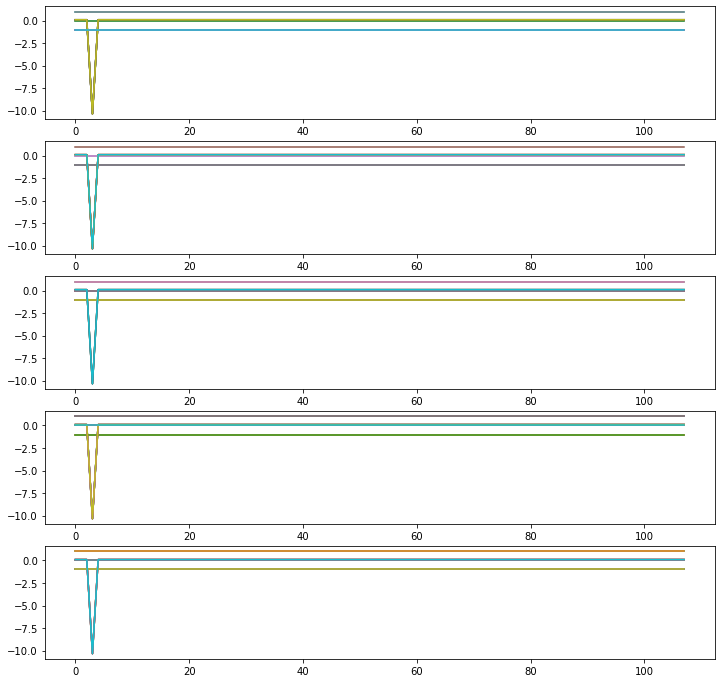

In [16]:
select_samples = 5
sample_from = random.randint(min(data_info["index_1"]), max(data_info["index_1"])-select_samples)
fig, ax = plt.subplots(select_samples,1,figsize=(12,12))
for i,j in enumerate(range(sample_from, sample_from+select_samples)):

    ax[i].plot(data[j][0].T)
plt.show()

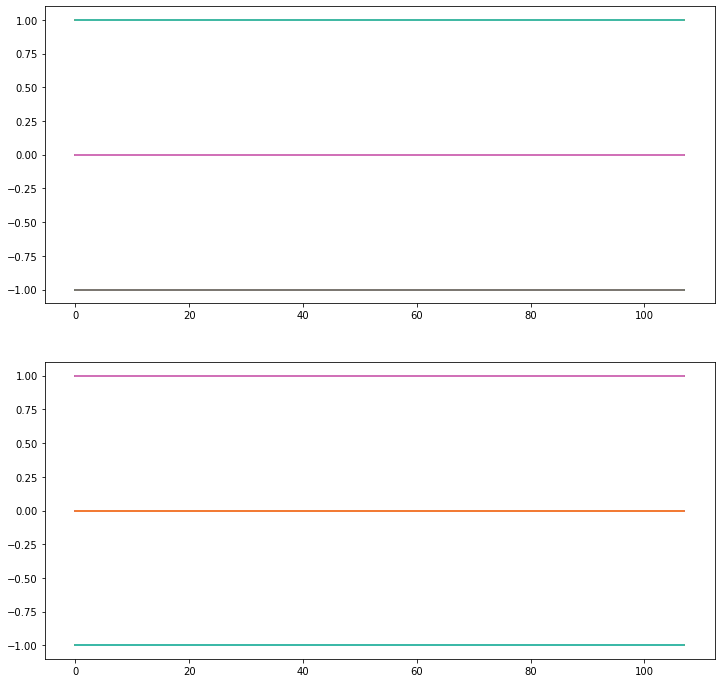

In [17]:
plot_example(select_samples=2, fail=0)

## Create dataset

In [18]:
time_steps=3
n_cells=108
failed_cell=50 
sigma=0.0
volt_stochastic = 0.9
normalize_x=False
random_cell_fail=False
n_healthy = 1000
n_fails = 100

data, data_info = create_data(n_healthy=n_healthy, n_fails=n_fails, time_steps=time_steps, random_cell_fail=random_cell_fail, failed_cell=failed_cell,sigma=sigma, volt_stochastic=volt_stochastic, n_cells=n_cells)

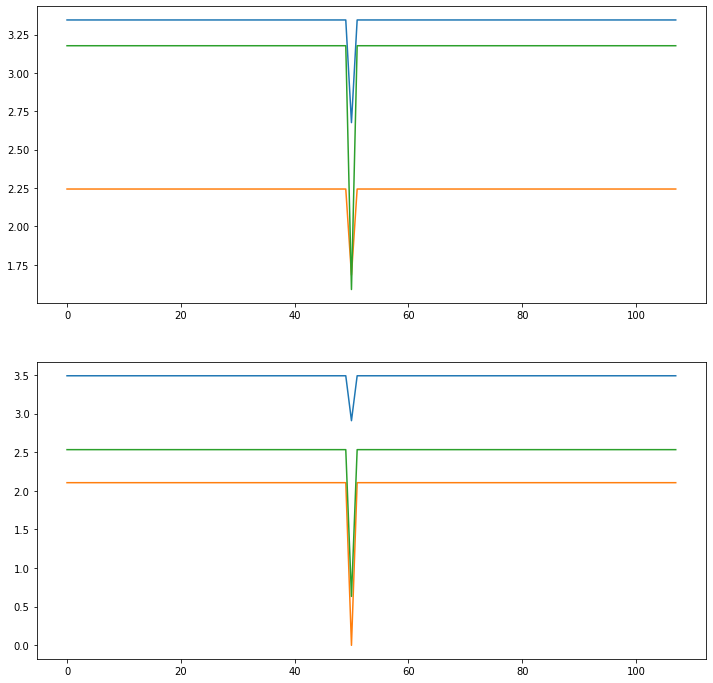

In [78]:
plot_example(select_samples=2, fail=1)

In [19]:
train_size = int(len(data)*0.8)
test_size = len(data) - train_size
train_set, test_set = torch.utils.data.random_split(data,[train_size, test_size])
batch_size = 10
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True,drop_last=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True,drop_last=True)

In [20]:
for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

NameError: name 'model' is not defined

In [21]:
class ANNMultilayerperceptron(nn.Module):

    def __init__(self, input_size=(time_steps*n_cells),output_size=2):  # 120, 84
        super().__init__()

        self.fc1 = nn.Linear(input_size, 200)
        self.fc2 = nn.Linear(200, 400)
        self.fc2b = nn.Linear(400, 1800)
        self.fc2c = nn.Linear(1800, 400)
        self.fc2d = nn.Linear(400, 200)
        self.fc3 = nn.Linear(200, output_size)

    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc2b(X))
        X = F.relu(self.fc2c(X))
        X = F.relu(self.fc2d(X))
        X = self.fc3(X)

        #return F.log_softmax(X,dim=1) # PGA multiclass classification
        return X

model = ANNMultilayerperceptron()
#model   

In [82]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
#optimizer = torch.optim.Adadelta(model.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [83]:
#from ignite.metrics import Precision, Recall
#from ignite.metrics import Precision ### LÄGG TILL IGNITE
#train_precision = Precision()
#train_recall = Recall()

#test_precision = Precision()
#test_recall = Recall()
# https://pytorch.org/ignite/metrics.html


epochs = 30 # Ju störra dataset ju färre epochs behövs

train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For loop epochs 

for i in range(epochs):
    trn_correct = 0
    tst_correct = 0 

    # Train

    for b, (X_train, y_train) in enumerate(train_loader):
        
        # Skip iteration if batch size not equal to stated dim
        
            
        #print(X_train.shape, y_train.shape) 
        
        b += 1
        
        y_pred = model(X_train.view(batch_size, -1))  # Flatten input
        lossTrain = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data,1)[1]

        #calculate precision and recall
        #train_precision.update((y_pred, y_train))
        #train_recall.update((y_pred, y_train))
      

        batch_corr = (predicted == y_train).sum()
        trn_correct += batch_corr

        optimizer.zero_grad()
        lossTrain.backward()
        optimizer.step()

        if b%10 == 0: 
            print(f"Epoch {i} Batch: {b} Train Loss: {lossTrain.item()}")

    train_losses.append(lossTrain.data.item())
    train_correct.append(trn_correct)

    # Test
    with torch.no_grad():
        for b, (X_test,y_test) in enumerate(test_loader):
            y_val = model(X_train.view(batch_size, -1))

            predicted = torch.max(y_val.data,1)[1]

            
        loss = criterion(y_val, y_test)
        test_losses.append(loss)
        test_correct.append(trn_correct)

        #if b%2 == 0:
            #print(f"Epoch {i} Batch: {b} Train Loss: {lossTrain.item()} Validation Loss: {loss.item()}")


Epoch 0 Batch: 10 Train Loss: 0.5319185256958008
Epoch 0 Batch: 20 Train Loss: 0.33015698194503784
Epoch 0 Batch: 30 Train Loss: 0.07508105039596558
Epoch 0 Batch: 40 Train Loss: 0.5793259143829346
Epoch 0 Batch: 50 Train Loss: 0.10070312023162842
Epoch 0 Batch: 60 Train Loss: 0.29111403226852417
Epoch 0 Batch: 70 Train Loss: 0.5826246738433838
Epoch 0 Batch: 80 Train Loss: 0.5422733426094055
Epoch 1 Batch: 10 Train Loss: 0.6019918322563171
Epoch 1 Batch: 20 Train Loss: 0.10555599629878998
Epoch 1 Batch: 30 Train Loss: 0.052001070231199265
Epoch 1 Batch: 40 Train Loss: 0.08610421419143677
Epoch 1 Batch: 50 Train Loss: 0.15253882110118866
Epoch 1 Batch: 60 Train Loss: 0.5007473230361938
Epoch 1 Batch: 70 Train Loss: 0.09778513014316559
Epoch 1 Batch: 80 Train Loss: 0.08252100646495819
Epoch 2 Batch: 10 Train Loss: 0.5284291505813599
Epoch 2 Batch: 20 Train Loss: 0.33166176080703735
Epoch 2 Batch: 30 Train Loss: 0.34991255402565
Epoch 2 Batch: 40 Train Loss: 0.3158954977989197
Epoch 2 Ba

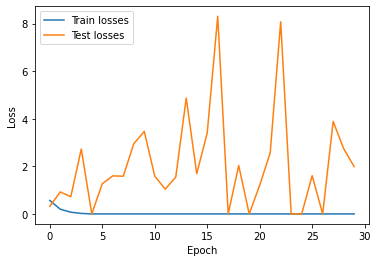

In [252]:
plt.plot(train_losses, label="Train losses")
plt.plot(test_losses, label= "Test losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

## Create confusion matrix

F1 score 0.7741935483870968


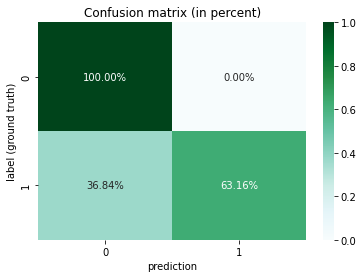

In [87]:
from sklearn.metrics import f1_score
test_loader_all = DataLoader(dataset=test_set, batch_size=len(test_set), shuffle=True,drop_last=True)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_loader_all:
        y_val = model(X_test.view(len(test_set),-1))
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        
# Create confusion matrix        
arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
f1 = f1_score(y_test.view(-1), predicted.view(-1))

arr2 = np.zeros([2,2])
#arr2[0] = (arr[0]/arr.sum())#.astype(int)
#arr2[1] = (arr[1]/arr.sum())#.astype(int)

arr2[0] = arr[0]/arr[0,:].sum()
arr2[1] = arr[1]/arr[1,:].sum()

df_cm = pd.DataFrame(arr2)
#sns.heatmap(df_cm, annot=True, cmap="BuGn")
sns.heatmap(df_cm, annot=True, cmap="BuGn",fmt='.2%')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.title("Confusion matrix (in percent)")
print(f"F1 score {f1}")
plt.show()